In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터셋 확인

In [72]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.6 MB/s eta 0:00:00


In [73]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

from torchvision import transforms
from torch.utils.data import DataLoader
from ipywidgets import interact
from pathlib import Path

In [3]:
data_dir = '/content/drive/Othercomputers/내 컴퓨터/GitHub/few shot learning/Face-Recognition/'
phase = 'train'

In [4]:
person_items = []

for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
    if len(files) > 0:
        for file_name in files:
            person_items.append(os.path.join(root, file_name))

In [5]:
len(person_items)

70

In [6]:
index = 0

faceA_path = person_items[index]

In [7]:
faceA_path

'/content/drive/Othercomputers/내 컴퓨터/GitHub/few shot learning/Face-Recognition/train/s1/6.png'

In [8]:
Path(faceA_path).parent

PosixPath('/content/drive/Othercomputers/내 컴퓨터/GitHub/few shot learning/Face-Recognition/train/s1')

In [9]:
Path(faceA_path).parent.name

's1'

In [10]:
person = Path(faceA_path).parent.name
same_person_dir = Path(faceA_path).parent

In [11]:
same_person_images = [fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]

In [12]:
np.random.choice(same_person_images)

'7.png'

In [13]:
faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_images))
faceB_path

'/content/drive/Othercomputers/내 컴퓨터/GitHub/few shot learning/Face-Recognition/train/s1/1.png'

In [14]:
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

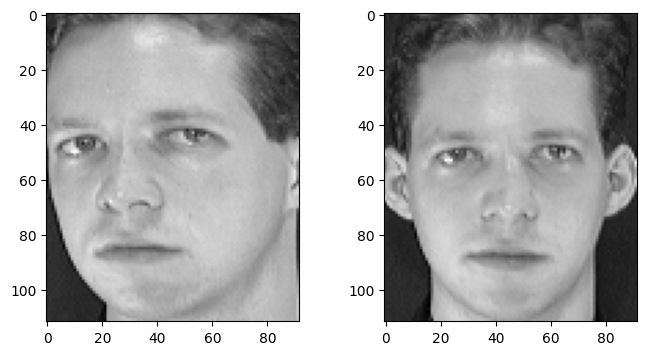

In [15]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

In [16]:
person = Path(faceA_path).parent.name
while True:
    faceB_path = np.random.choice(person_items)
    if person != Path(faceB_path).parent.name:
        break

In [17]:
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

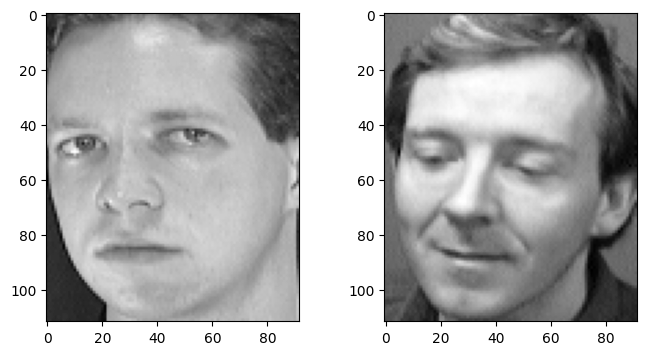

In [18]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

## 데이터셋 구축

In [19]:
class MyDataset():
    def __init__(self, data_dir, phase, transform=None):
        self.person_items = []

        for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
            if len(files) > 0:
                for file_name in files:
                    self.person_items.append(os.path.join(root, file_name))

        self.transform = transform

    def __len__(self):
        return len(self.person_items)

    def __getitem__(self, index):
        faceA_path = self.person_items[index]
        person = Path(faceA_path).parent.name

        same_person = np.random.randint(2) # 0, 1 값 중 하나 반환

        if same_person: # 1
            same_person_dir = Path(faceA_path).parent
            same_person_fn = [fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]
            faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_fn))
        else:          # 0
            while True:
                faceB_path = np.random.choice(self.person_items)
                if person != Path(faceB_path).parent.name:
                    break

        faceA_image = cv2.imread(faceA_path, 0)
        faceB_image = cv2.imread(faceB_path, 0)

        if self.transform:
            faceA_image = self.transform(faceA_image)
            faceB_image = self.transform(faceB_image)

        return faceA_image, faceB_image, np.array([1 - same_person]) # labels => 동일 인물 : 0 / 다른 인물 : 1

In [20]:
trainset = MyDataset(data_dir, 'train')

label:  [0]


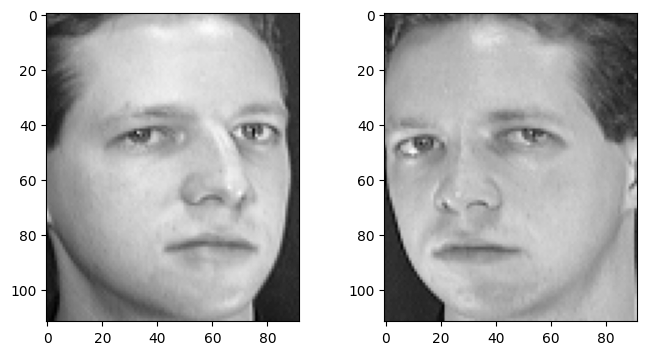

In [21]:
index = 2
faceA, faceB, label = trainset[index]
print('label: ', label)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(faceA, cmap='gray')
plt.subplot(122)
plt.imshow(faceB, cmap='gray')
plt.show()

In [22]:
@interact(index = (0, len(trainset)-1))
def show_image(index=0):
    faceA, faceB, label = trainset[index]
    print('label: ', label)

    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(faceA, cmap='gray')
    plt.subplot(122)
    plt.imshow(faceB, cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

In [23]:
def build_transform(image_size=100):
    transform = {}
    transform['train'] = transforms.Compose([
                                            transforms.ToPILImage(),
                                            transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.Resize((image_size, image_size)),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5), (0.5))
                                            ])

    transform['val'] = transforms.Compose([
                                            transforms.ToPILImage(),
                                            transforms.Resize((image_size, image_size)),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5), (0.5))
                                            ])

    return transform

In [24]:
IMAGE_SIZE = 100
transform = build_transform(image_size=IMAGE_SIZE)

In [25]:
train_dataset = MyDataset(data_dir=data_dir, phase='train', transform=transform['train'])
val_dataset = MyDataset(data_dir=data_dir, phase='val', transform=transform['val'])

In [26]:
def build_dataloader(data_dir, batch_size):
    dataloaders = {}

    transform = build_transform(image_size=IMAGE_SIZE)
    train_dataset = MyDataset(data_dir=data_dir, phase='train', transform=transform['train'])
    val_dataset = MyDataset(data_dir=data_dir, phase='val', transform=transform['val'])

    dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dataloaders['val'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return dataloaders

In [27]:
BATCH_SIZE = 64
dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ce85bdce6e0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7ce862cb3460>}

In [28]:
for _ in range(3):
    for phase in ['train', 'val']:
        for index, batch in enumerate(dataloaders[phase]):
            faceA = batch[0]
            faceB = batch[1]
            labels = batch[2]

            if index % 100 == 0:
                print(f'{phase} - {index}/{len(dataloaders[phase])}')

train - 0/2
val - 0/1
train - 0/2
val - 0/1
train - 0/2
val - 0/1


## siamese network 아키텍쳐 구현

In [29]:
def ConvBlock(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel)
    )

In [30]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_channel):
        super().__init__()

        self.features = nn.Sequential(
            ConvBlock(input_channel, 4),
            ConvBlock(4, 8),
            ConvBlock(8, 8),
            nn.Flatten(),
            nn.Linear(8*100*100, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x1, x2):
        z1 = self.features(x1)
        z2 = self.features(x2)
        return z1, z2

In [31]:
IMAGE_SIZE = 100
x1 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)
x2 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)

model = SiameseNetwork(input_channel=1)

z1, z2 = model(x1, x2)

In [32]:
z1.shape, z2.shape

(torch.Size([1, 10]), torch.Size([1, 10]))

### Contrastive Loss Function

In [33]:
class ContranstiveLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()

        self.margin = margin

    def forward(self, z1, z2, label):
        dist = F.pairwise_distance(z1, z2, keepdim=True)
        # same : 0 / other : 1
        loss = torch.mean((1 - label) * torch.pow(dist, 2) + label * torch.pow(torch.clamp((self.margin - dist), min=0), 2))
        acc = ((dist > 0.6) == label).float().mean()

        return loss, acc

## Training

In [42]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    losses = {}
    accuracies = {}

    for phase in ['train', 'val']:
        running_loss = 0.0
        running_acc = 0.0

        if phase == 'train':
            model.train()
        else:
            model.eval()

        for index, batch in enumerate(dataloaders[phase]):
            imageA = batch[0].to(device)
            imageB = batch[1].to(device)
            label = batch[2].to(device)

            with torch.set_grad_enabled(phase == 'train'): # train 일 때만 grad 추적기능 켜기
                codeA, codeB = model(imageA, imageB)

            loss, acc = criterion(codeA, codeB, label)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            running_acc += acc.item()
        losses[phase] = running_loss / len(dataloaders[phase])
        accuracies[phase] = running_acc / len(dataloaders[phase])

    return losses, accuracies

In [35]:
def save_model(model_state, model_name):
    os.makedirs('./trained_model', exist_ok=True)
    torch.save(model_state, os.path.join('./trained_model', model_name))

In [36]:
IMAGE_SIZE = 100
BATCH_SIZE = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
model = SiameseNetwork(input_channel=1)
model.to(DEVICE)
criterion = ContranstiveLoss(margin=2.0)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [37]:
num_epochs = 100
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(num_epochs):
    losses, accuracies = train_one_epoch(dataloaders=dataloaders, model=model, criterion=criterion, optimizer=optimizer, device=DEVICE)
    train_loss.append(losses['train'])
    train_acc.append((accuracies['train']))
    val_loss.append(losses['val'])
    val_acc.append((accuracies['val']))

    print(f'{epoch}/{num_epochs}\t | train loss: {losses["train"]:.4f}\t | val loss: {losses["val"]:.4f}\t | train acc: {accuracies["train"]:.4f}\t | val acc: {accuracies["val"]:.4f}')

    if (epoch+1) % 10 == 0:
        save_model(model.state_dict(), f'model_{epoch+1}.pth')

0/100	 | train loss: 1.4702	 | val loss: 1.7277	 | train acc: 0.5286	 | val acc: 0.5667
1/100	 | train loss: 1.5383	 | val loss: 2.1249	 | train acc: 0.4857	 | val acc: 0.4667
2/100	 | train loss: 0.9782	 | val loss: 2.3871	 | train acc: 0.6571	 | val acc: 0.4000
3/100	 | train loss: 1.1686	 | val loss: 1.0589	 | train acc: 0.6143	 | val acc: 0.7333
4/100	 | train loss: 1.0192	 | val loss: 1.5823	 | train acc: 0.5714	 | val acc: 0.6000
5/100	 | train loss: 1.1258	 | val loss: 2.2270	 | train acc: 0.5143	 | val acc: 0.4333
6/100	 | train loss: 1.0039	 | val loss: 2.4731	 | train acc: 0.5286	 | val acc: 0.3667
7/100	 | train loss: 0.9267	 | val loss: 2.0559	 | train acc: 0.6000	 | val acc: 0.4667
8/100	 | train loss: 0.8218	 | val loss: 2.1614	 | train acc: 0.6143	 | val acc: 0.4333
9/100	 | train loss: 0.9011	 | val loss: 1.6114	 | train acc: 0.5000	 | val acc: 0.5667
10/100	 | train loss: 0.4483	 | val loss: 2.4311	 | train acc: 0.7429	 | val acc: 0.3333
11/100	 | train loss: 0.5133	 |

In [ ]:
train_loss
train_acc
val_loss
val_acc

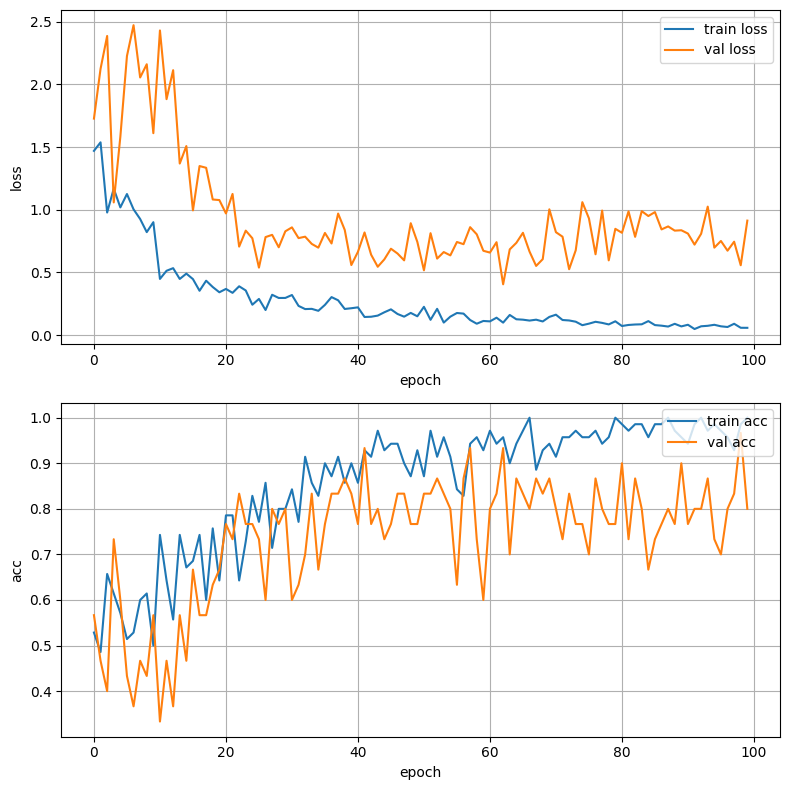

In [39]:
plt.figure(figsize=(8, 8))

plt.subplot(211)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend(loc='upper right')
plt.tight_layout()

plt.subplot(212)
plt.plot(train_acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.xlabel("epoch")
plt.ylabel("acc")
plt.grid("on")
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

### Tensorboard로 Latent vector 시각화

In [65]:
class MyDataset():
    def __init__(self, data_dir, transform=None):
        self.person_items = []

        for root, dirs, files in os.walk(data_dir):
            if len(files) > 0:
                for file_name in files:
                    self.person_items.append(os.path.join(root, file_name))
        self.transform = transform

    def __len__(self):
        return len(person_items)

    def __getitem__(self, index):
        face_path = self.person_items[index]
        face_image = cv2.imread(face_path, 0)

        if self.transform:
            face_image = self.transform(face_image)

        person_name = Path(face_path).parent.name

        return face_image, person_name

In [66]:
dataset = MyDataset(data_dir=data_dir)
len(dataset)

100

In [67]:
dataset[0]

(array([[ 43,  50,  41, ...,  55,  55,  56],
        [ 45,  53,  44, ...,  67,  62,  52],
        [ 57,  47,  47, ...,  45,  59,  55],
        ...,
        [ 49,  49,  46, ..., 154, 152, 175],
        [ 46,  48,  47, ..., 157, 150, 174],
        [ 49,  50,  43, ..., 158, 153, 169]], dtype=uint8),
 's1')

In [68]:
def build_transform(image_size=100):
    transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((image_size, image_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5), (0.5))
                                    ])

    return transform

In [75]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_channel):
        super().__init__()

        self.features = nn.Sequential(
            ConvBlock(input_channel, 4),
            ConvBlock(4, 8),
            ConvBlock(8, 8),
            nn.Flatten(),
            nn.Linear(8*100*100, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x1):
        z1 = self.features(x1)
        return z1

In [76]:
def load_model(ckpt_path, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = SiameseNetwork(input_channel=1)
    model.load_state_dict(checkpoint)
    print('model state: ', model.load_state_dict(checkpoint))
    model.eval()
    model.to(device)

    return model

In [77]:
ckpt_path = '/content/trained_model/model_100.pth'

IMAGE_SIZE = 100
DEVICE = torch.device('cpu')

transform = build_transform(image_size=100)
dataset = MyDataset(data_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

model = load_model(ckpt_path, DEVICE)
model

model state:  <All keys matched successfully>


SiameseNetwork(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=80000, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [78]:
writer = SummaryWriter('run/face_features')

In [81]:
all_images = []
all_labels = []
all_embeds = []

for index, batch in enumerate(dataloader):
    image = batch[0]
    label = batch[1]

    with torch.no_grad():
        embed = model(image.to(DEVICE))
    embed = embed.detach().numpy()

    image = make_grid(image, normalize=True).permute(1, 2, 0)
    image = cv2.resize(np.array(image), dsize=(80, 80), interpolation=cv2.INTER_NEAREST)

    all_images.append(image)
    all_labels.append(label)
    all_embeds.append(embed)

all_images = torch.Tensor(np.moveaxis(np.stack(all_images, axis=0), 3, 1))
all_embeds = torch.Tensor(np.stack(all_embeds, axis=0).squeeze(1))
all_labels = np.concatenate(all_labels).tolist()
# all_labels = np.stack(all_labels, axis=1).squeeze(0)

writer.add_embedding(all_embeds, label_img = all_images, metadata_header=all_labels)
writer.close()

In [84]:
# 실행은 vscode or jupyter notebook

In [99]:
%load_ext tensorboard
%tensorboard --logdir "/content/run" --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


UsageError: Line magic function `%tensorboard.exe` not found.


In [95]:
!lsof -i:6006

COMMAND     PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
tensorboa 27635 root   14u  IPv4 729417      0t0  TCP localhost:6006 (LISTEN)


In [96]:
!kill PID '27635'

/bin/bash: line 1: kill: PID: arguments must be process or job IDs
